<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Задача" data-toc-modified-id="Задача-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Задача</a></span></li><li><span><a href="#Загрузка-и-исследовательский-анализ-данных" data-toc-modified-id="Загрузка-и-исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и исследовательский анализ данных</a></span></li><li><span><a href="#Базовая-модель-Matching-на-основе-FAISS" data-toc-modified-id="Базовая-модель-Matching-на-основе-FAISS-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Базовая модель Matching на основе FAISS</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#Вывод-по-проекту-и-дальнейшие-шаги" data-toc-modified-id="Вывод-по-проекту-и-дальнейшие-шаги-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод по проекту и дальнейшие шаги</a></span></li></ul></div>

## Задача

**Исходные данные**

base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

validation_answer.csv - правильные ответы к предыдущему файлу.

**Задача:** 

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;

- оценить качество алгоритма по метрике accuracy@5

- *деплой: разработать REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.


## Загрузка и исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from catboost import CatBoostClassifier

Предобработка данных заключается в проверке на:
- соответствующие типы данных
- явные и неявные дубликаты
- выбросы
- пропуски

In [2]:
try:
    df_base = pd.read_csv("/Users/coldpiold/Desktop/practicum/мастерская_2/base.csv", index_col=0)
except:
    df_base = pd.read_csv('base.csv', index_col=0)


In [3]:
display(df_base.head(5))

print(df_base.info())

print(df_base.shape)
    
dupl = df_base.duplicated().sum()
print(f'дубликаты в данных: {dupl}')
  

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


In [4]:
try:
    df_train = pd.read_csv("/Users/coldpiold/Desktop/practicum/мастерская_2/train.csv", index_col=0)
except:
    df_train = pd.read_csv("train.csv", index_col=0)


In [5]:
display(df_train.head())  

print(df_train.info())

print(df_train.shape)
    
dupl = df_train.duplicated().sum()
print(f'дубликаты в данных: {dupl}')

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

In [6]:
try:
    df_valid = pd.read_csv("/Users/coldpiold/Desktop/practicum/мастерская_2/validation.csv", index_col=0)
except:
    df_valid = pd.read_csv("validation.csv", index_col=0)

print(df_valid.info())

print(df_valid.shape)
    
dupl = df_valid.duplicated().sum()
print(f'дубликаты в данных: {dupl}')

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

In [7]:
try:
    df_valid_answer = pd.read_csv("/Users/coldpiold/Desktop/practicum/мастерская_2/validation_answer.csv", index_col=0)
except:
    df_valid_answer = pd.read_csv("validation_answer.csv", index_col=0)

print(df_valid_answer.info())

print(df_valid_answer.shape)
    
dupl = df_valid_answer.duplicated().sum()
print(f'дубликаты в данных: {dupl}')

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB
None
(100000, 1)
дубликаты в данных: 8498


**Промежуточные выводы:**

- В данных нет пропусков и дубликатов.
- Данные всех признаков необходимо масштабировать

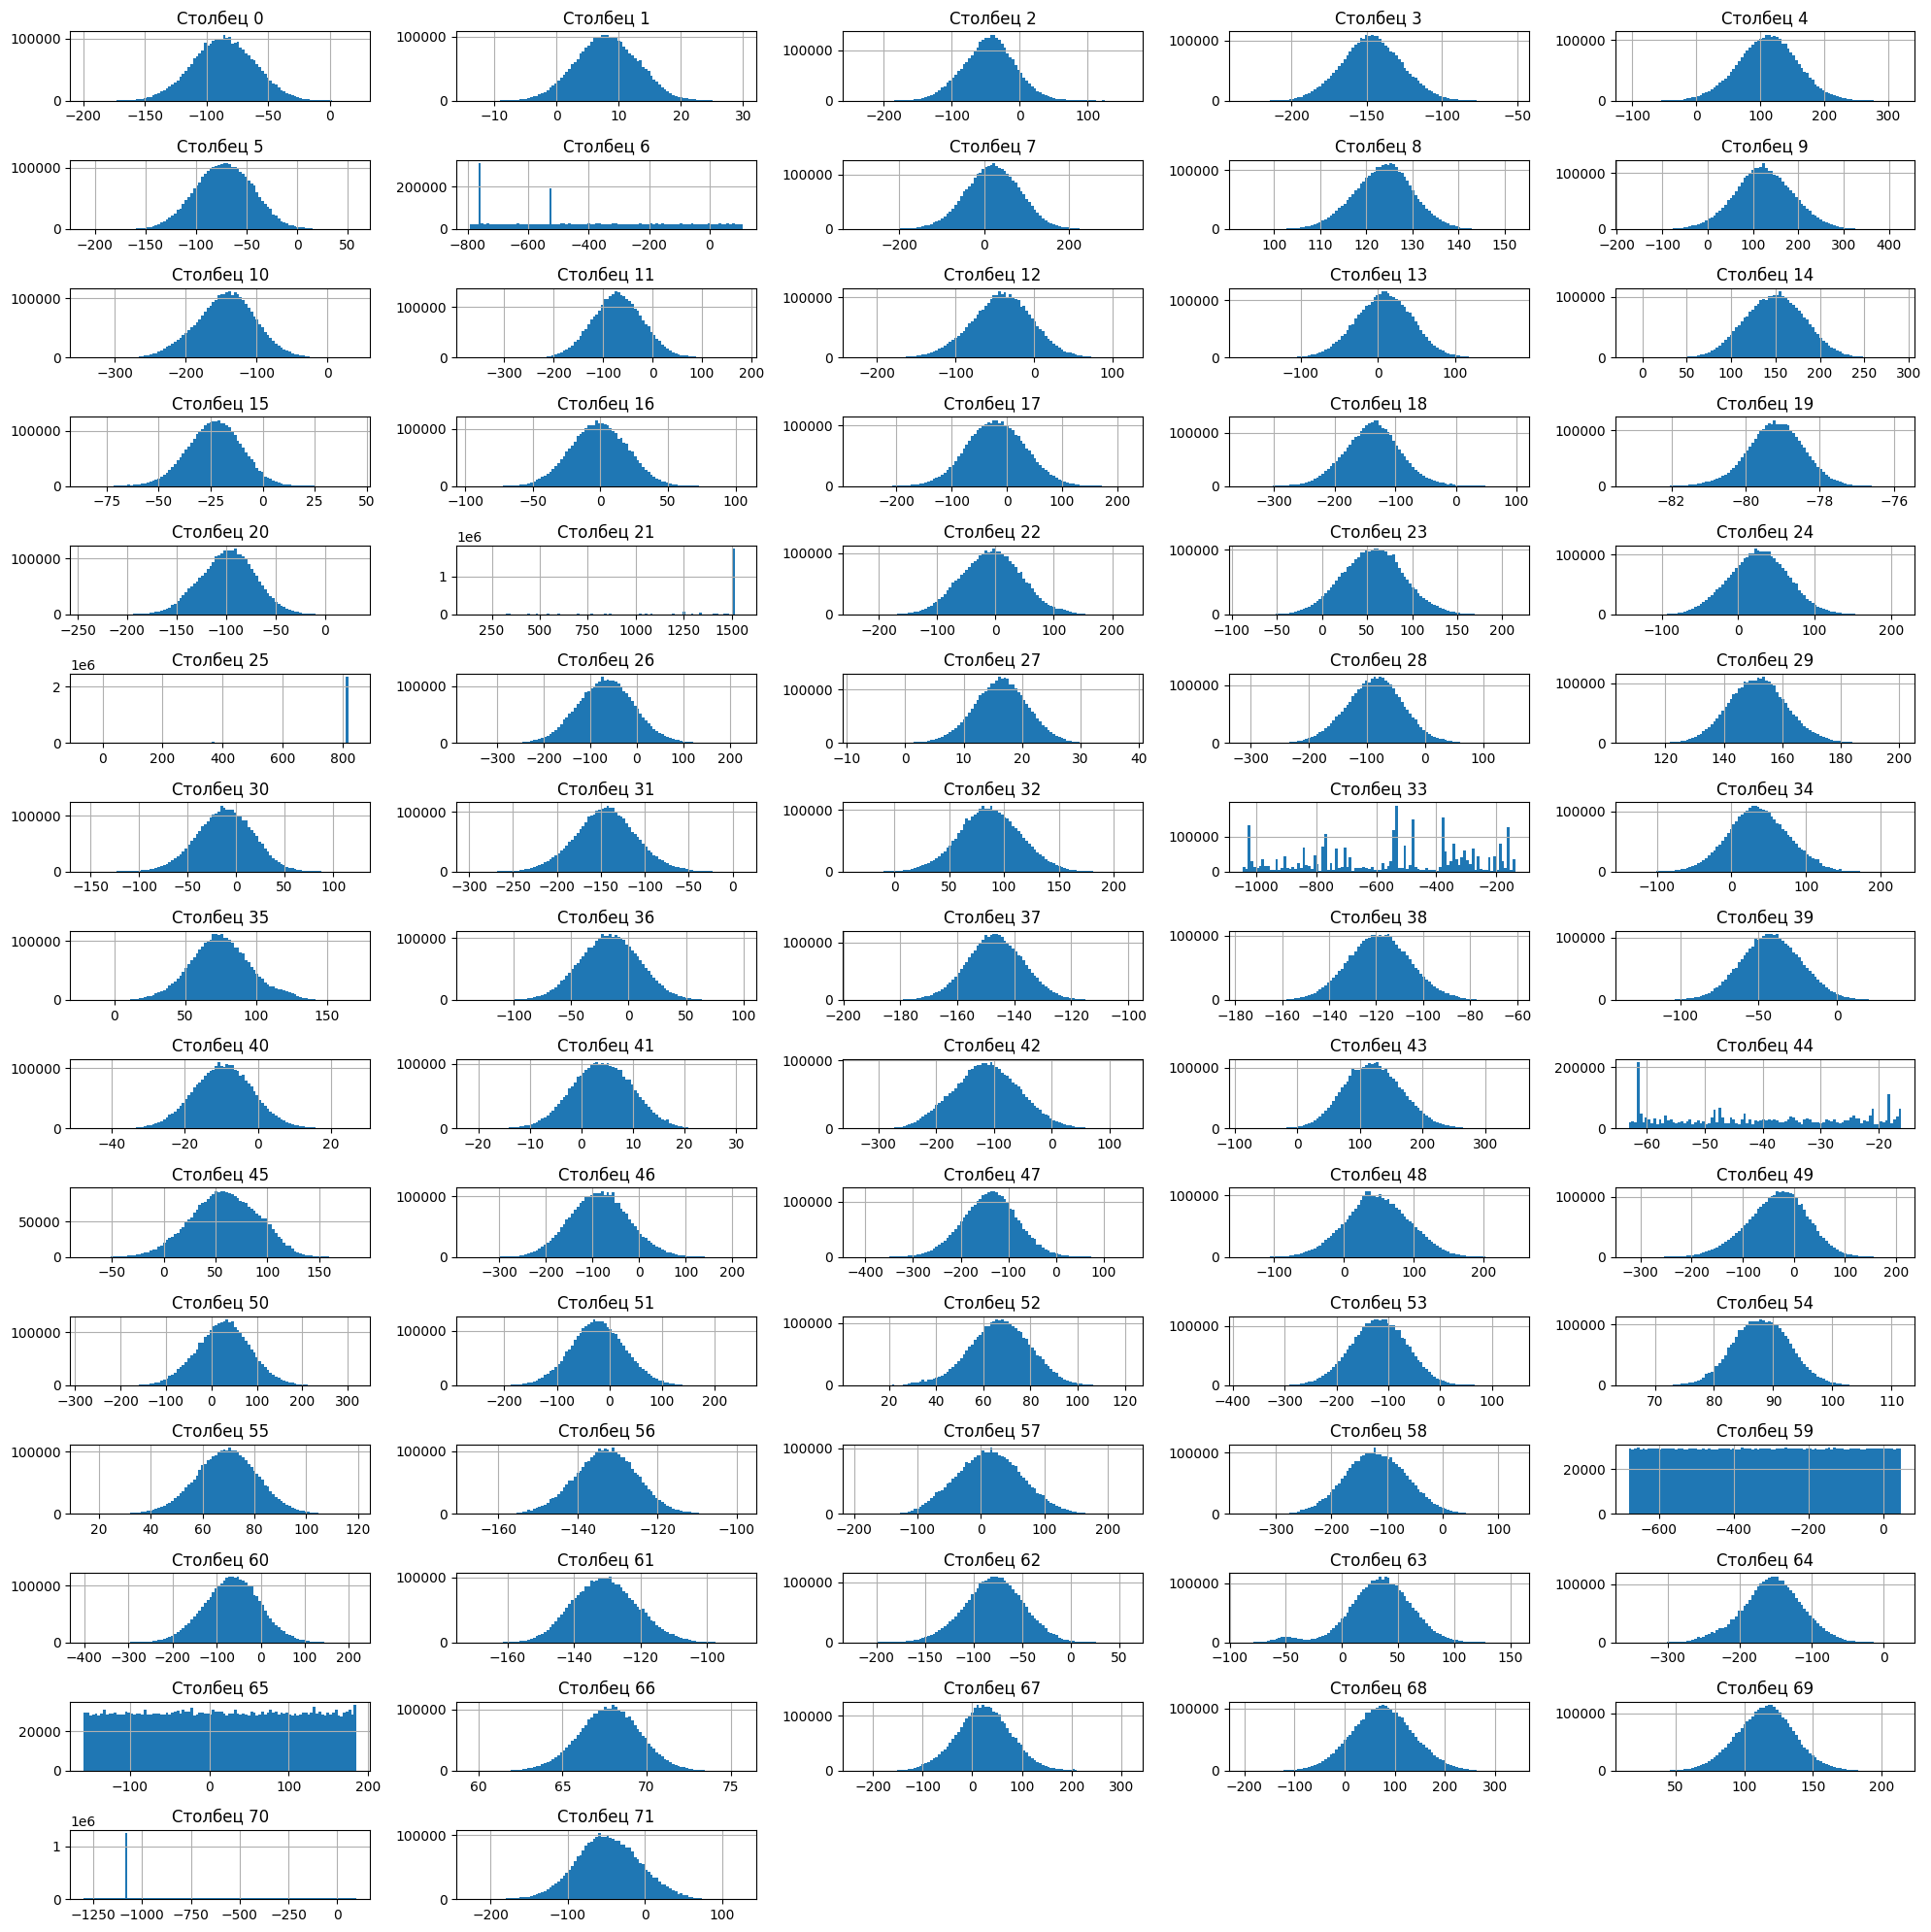

In [8]:
num_columns = df_base.shape[1]
num_rows = 15
num_cols = 5 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    if i < num_columns:
        df_base.iloc[:, i].hist(bins=100, ax=ax)
        ax.set_title(f'Столбец {i}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

**Промежуточные выводы:**

- Некоторые признаки имеют ненормальное распределение и будут удалены для выполнения первого этапа анализа на основе моделей FAISS
- Прочие признаки будут масштабированы методом Standard Scaler так как имеют примерно нормальное распределение

In [9]:
df_base_non_normal = ['70','65','59','44','33','25','21','6']
df_base_normal = ['0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '26', '27', '28', '29', '30', '31', '32' 
        , '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '60',
       '61', '62', '63','64', '66', '67', '68', '69', '71']

In [10]:
df_base_nnormal = df_base[df_base_non_normal]
df_base.drop(columns=df_base_non_normal,inplace=True)

In [11]:
df_valid_nnormal = df_valid[df_base_non_normal]
df_valid.drop(columns=df_base_non_normal,inplace=True)

In [12]:
df_train_nnormal = df_train[df_base_non_normal]
df_train.drop(columns=df_base_non_normal,inplace=True)

In [13]:
st_scaler = StandardScaler()

st_scaler.fit(df_base[df_base_normal])

df_base_st_scaled = pd.DataFrame(data=st_scaler.transform(df_base[df_base_normal]),
                                index=df_base.index,
                                columns=df_base_normal)

df_base_scaled = df_base_st_scaled.copy() 

display(df_base_scaled.head(5))

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,0.373663,-0.435627,0.884544,0.457647,...,0.006792,-0.847513,1.189049,0.190524,0.073589,-2.262493,-0.510438,0.293004,-0.014051,-0.312329
1-base,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,-0.871900,-0.623903,1.098487,0.044024,...,1.221724,-1.871023,-1.272135,0.270119,-0.073569,0.225102,0.014491,1.711283,0.059848,-0.281052
2-base,1.285417,-0.343342,0.397878,0.666228,0.853956,-0.973671,0.654489,0.828686,0.619635,0.055584,...,-0.586374,-0.417020,0.086191,0.440159,-1.269686,-1.220546,0.773022,0.099669,0.048521,0.365623
3-base,-0.051852,-0.816047,-1.118829,-1.936660,-0.754014,0.461441,-0.840347,-0.259958,0.182763,0.831647,...,-0.394438,-1.949926,0.274980,-1.372853,0.184217,-0.871349,-0.797073,1.014714,0.090076,-0.601807
4-base,0.541780,-0.314538,2.284450,0.303705,-2.276181,-1.422075,0.386656,-0.238677,-0.191508,0.786741,...,-0.570116,0.559135,0.716557,0.808178,-0.110496,-0.562342,-0.470720,-0.157210,0.920175,1.152406


In [14]:
df_train.head(5)

,0,1,2,3,4,5,7,8,9,10,...,61,62,63,64,66,67,68,69,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,38.307602,109.085560,30.413513,-88.08269,...,-132.38617,-105.427820,70.107360,-155.80257,65.903790,34.457500,62.642094,134.763600,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-78.433090,124.915900,140.331070,-177.60580,...,-137.41136,-40.812233,4.669178,-151.69771,68.170876,25.096191,89.974976,130.589630,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,-30.447489,125.771164,211.607820,-86.34656,...,-139.22307,-52.031662,78.039764,-169.14620,66.008220,18.400496,212.409730,121.931470,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,79.186520,124.003100,242.650650,-146.51707,...,-131.19829,-61.567047,44.515266,-145.41675,64.131350,106.061920,83.178760,118.277725,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,45.984676,125.941284,103.392670,-107.15302,...,-103.34170,-68.770600,45.028910,-196.09207,66.926220,42.456170,77.621765,92.479930,-21.149351,717819-base


In [15]:
df_train_st_scaled = pd.DataFrame(data=st_scaler.transform(df_train[df_base_normal]),
                                index=df_train.index,
                                columns=df_base_normal)

df_train_scaled = df_train_st_scaled.copy() 

display(df_train_scaled.head(5))

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,-0.193435,-0.179583,-0.866975,1.274319,-0.024410,-1.035388,0.197184,-0.200786,0.906575,0.522963
1-query,-0.062146,-0.257159,0.324249,-1.543245,0.204684,-0.419328,-1.538329,0.193777,0.246358,-0.826778,...,1.382837,-0.704733,1.254600,-0.991073,0.075152,0.207972,0.028031,0.244774,0.709459,-0.083491
2-query,1.456328,-0.855696,-1.851792,-1.701553,1.700433,0.750504,-0.791080,0.328335,1.352615,1.362356,...,-0.126222,-0.894063,0.886224,1.548929,-0.348054,-0.978114,-0.092956,2.240614,0.300576,0.604677
3-query,1.543467,0.203199,-1.833235,1.291201,-0.359536,-1.322073,0.916179,0.050167,1.834418,-0.081019,...,-1.416759,-0.055445,0.573141,0.388351,0.227494,-2.007464,1.491032,0.133987,0.128028,0.668019
4-query,0.265046,1.284537,-0.370748,-0.021041,-1.169187,1.977993,0.399148,0.355099,-0.326947,0.863249,...,-1.005156,2.855665,0.336621,0.406133,-1.001615,-0.474647,0.341715,0.043401,-1.090276,0.638160


In [16]:
df_valid_st_scaled = pd.DataFrame(data=st_scaler.transform(df_valid[df_base_normal]),
                                index=df_valid.index,
                                columns=df_base_normal)

df_valid_scaled = df_valid_st_scaled.copy()

display(df_valid_scaled.head(5))

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,1.767701,-1.413223,0.115241,0.676228,0.275453,0.817488,0.693550,0.597167,-0.020121,-1.659674
100001-query,1.304502,0.950910,0.033969,0.615646,0.067603,-0.657373,0.679613,0.540216,-1.107069,-0.253738,...,-0.548876,-1.135690,-0.013756,-0.142350,-0.334949,1.631021,-1.617587,0.360549,0.369533,0.545701
100002-query,0.886027,-2.434901,0.955216,-1.185496,-0.320843,0.341078,1.045290,1.193478,0.690080,-1.851159,...,1.127774,0.402836,-1.831225,0.140946,-0.118026,-0.044550,1.128563,1.021715,1.204944,-0.555197
100003-query,-0.524576,1.623911,1.408637,-0.071830,-0.595916,-2.190385,-0.613543,-1.359610,-0.764409,0.692479,...,0.783558,0.268198,0.058666,0.373992,0.540055,1.695934,0.000596,0.949135,1.307485,-0.996489
100004-query,0.269032,-1.704743,0.739119,-1.221980,1.168059,1.550401,0.218922,0.821217,-0.347213,1.605413,...,0.856405,-0.512342,-1.469227,0.427148,0.498123,1.549868,-0.148400,1.297723,-0.654827,-1.856774


## Базовая модель Matching на основе FAISS

Модель на основе FAISS будет обучена на основе тренировочного набора данных и протестирована на валидационном наборе данных. В моделе будет использован IVF индекс, количество кластеров подобрано на уровне 1700 штук (квадратный корень из количества записей в базовом датасете), количество "посещаемых кластеров" установлено на уровне 50 штук. При этом для каждого товара из тренировочной или валидационной выборки будет подобрано по 10 ближайших соседей.

In [17]:
dims = df_base_scaled.shape[1]
n_cells = 1700

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [18]:
idx_l2.nprobe = 50

In [19]:
idx_l2.train(np.ascontiguousarray(df_base_scaled.values).astype('float32'))

In [20]:
idx_l2.add(np.ascontiguousarray(df_base_scaled.values).astype('float32'))

In [21]:
base_index = {k: v for k, v in enumerate(df_base_scaled.index.to_list())}

In [22]:
targets = df_train["Target"]

In [23]:
r, idx = idx_l2.search(np.ascontiguousarray(df_train_scaled.values).astype('float32'), 10)

In [24]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

73.209


**Промежуточные выводы**

- С заданными параметрами точность подбора ближайших соседей на тренировочной выборке равна 73%
- Далее данные тренирочоной и базовой выборок будут подготовлены для обучения в моделе градиентного бустинга

In [25]:
index_train = df_train_scaled.index

In [26]:
df_train_25 = df_train_scaled.loc[df_train_scaled.index.repeat(10)]

In [27]:
index_train_25 = df_train_25.index

In [28]:
train_base = pd.DataFrame(data=idx,index=index_train)

train_base = pd.DataFrame({'base_index': train_base.stack().reset_index(drop=True)})
train_base['train_index'] = index_train_25

In [29]:
train_base = train_base.reset_index(drop=True)
train_base['key'] = train_base.index

In [30]:
df_train_25['train_index'] = df_train_25.index
df_train_25 = df_train_25.reset_index(drop=True)
df_train_25['key'] = df_train_25.index

In [31]:
train_merged = pd.merge(df_train_25,train_base,on='key')

In [32]:
train_merged = pd.merge(train_merged,train_base,on='key')

In [33]:
train_merged.drop(columns=['key','train_index_y','base_index_y','train_index'],inplace=True)

In [34]:
train_merged.rename(columns={"train_index_x": "train_query_n", "base_index_x": "base_index_candidate"},inplace=True)

In [35]:
df_base_scaled['base_index'] = df_base_scaled.reset_index().index

In [36]:
base_ind_df = pd.DataFrame(data=df_train["Target"],index=df_train.index)
base_map = pd.DataFrame(data=df_base_scaled['base_index'])
base_map['def_base_index'] = base_map.index

In [37]:
base_map.columns = ['base_index','Target']

In [38]:
base_ind_df = pd.merge(base_ind_df,base_map,on='Target',how='left')

In [39]:
base_ind_df.columns = ['query_answer','answer_base_index']

In [40]:
base_ind_df['train_query_n'] = df_train.index

In [41]:
train_merged = pd.merge(train_merged,base_ind_df,on='train_query_n',how='left')

In [42]:
df_base_scaled.rename(columns={'base_index':'base_index_candidate'},inplace=True)

In [43]:
train_merged = pd.merge(train_merged,df_base_scaled,on='base_index_candidate',how='left')

In [44]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [45]:
print(train_merged.columns.tolist())

['0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '22_x', '23_x', '24_x', '26_x', '27_x', '28_x', '29_x', '30_x', '31_x', '32_x', '34_x', '35_x', '36_x', '37_x', '38_x', '39_x', '40_x', '41_x', '42_x', '43_x', '45_x', '46_x', '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x', '54_x', '55_x', '56_x', '57_x', '58_x', '60_x', '61_x', '62_x', '63_x', '64_x', '66_x', '67_x', '68_x', '69_x', '71_x', 'train_query_n', 'base_index_candidate', 'query_answer', 'answer_base_index', '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '7_y', '8_y', '9_y', '10_y', '11_y', '12_y', '13_y', '14_y', '15_y', '16_y', '17_y', '18_y', '19_y', '20_y', '22_y', '23_y', '24_y', '26_y', '27_y', '28_y', '29_y', '30_y', '31_y', '32_y', '34_y', '35_y', '36_y', '37_y', '38_y', '39_y', '40_y', '41_y', '42_y', '43_y', '45_y', '46_y', '47_y', '48_y', '49_y', '50_y', '51_y', '52_y', '53_y', '54_y', '55_y', '56_y', '57_y', '58

In [46]:
def is_target(row):
    if row['answer_base_index'] == row['base_index_candidate']:
        return 1
    else:
        return 0

In [47]:
train_merged['is_target'] = train_merged.apply(is_target,axis=1)

In [48]:
train_merged.drop(columns=['train_query_n','base_index_candidate','query_answer','answer_base_index'],inplace=True)

In [49]:
df_train_target = df_train_scaled.copy()
df_train_target['train_query_n'] = df_train_target.index


In [50]:
df_train_target = pd.merge(df_train_target,base_ind_df,on = 'train_query_n',how='left')
display(df_train_target.head(5))

,0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,66,67,68,69,71,train_query_n,query_answer,answer_base_index
0,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.279598,-2.296794,-1.459626,1.320710,0.335633,0.348338,-0.074182,1.467578,-0.528330,-0.137619,-2.199224,-0.526967,0.893981,0.135834,-1.218252,0.632892,2.088698,-0.138746,-0.795630,-2.008673,-0.200075,-0.533139,0.317073,0.689298,0.313108,-0.793275,1.575643,-0.460325,1.082610,0.384758,-0.379061,-0.244658,-0.144466,0.623425,0.727980,-0.489634,-1.815781,-0.913808,-1.712483,0.714613,-0.330307,-0.310548,-0.269749,0.243144,1.492605,1.487568,-0.395721,-1.573302,-0.193435,-0.179583,-0.866975,1.274319,-0.024410,-1.035388,0.197184,-0.200786,0.906575,0.522963,0-query,675816-base,598613
1,-0.062146,-0.257159,0.324249,-1.543245,0.204684,-0.419328,-1.538329,0.193777,0.246358,-0.826778,-0.294981,2.157804,-1.771830,-1.551709,0.298688,0.080464,1.320173,-0.385964,0.699576,0.195050,-0.537200,0.751247,-1.416127,-1.158335,2.207661,-1.039072,0.160884,2.086926,0.814522,0.008768,-0.278611,0.778098,-0.547298,1.009545,-1.672834,-0.081826,0.275359,0.722288,-0.090823,0.605429,1.132864,0.392376,0.946494,-0.231800,0.155840,0.805338,0.281748,0.678224,0.106981,-1.082974,-1.266821,-0.140726,-0.770735,-1.720258,1.382837,-0.704733,1.254600,-0.991073,0.075152,0.207972,0.028031,0.244774,0.709459,-0.083491,1-query,366656-base,341406
2,1.456328,-0.855696,-1.851792,-1.701553,1.700433,0.750504,-0.791080,0.328335,1.352615,1.362356,0.668101,1.479850,-2.415226,-0.329309,-0.027972,-2.223497,0.050269,-1.227532,1.077830,1.027371,-0.878850,-2.643714,0.674421,0.783830,0.995513,0.743161,0.696336,0.407097,-1.117370,0.424820,-2.206801,1.052243,0.217402,0.222918,-1.164573,-1.928611,-0.942296,0.071421,0.856565,0.722909,-0.324238,-0.593699,0.446080,0.122435,0.021703,1.378345,0.738322,0.836741,0.407248,0.718825,-0.509248,0.763422,-0.101015,-1.377149,-0.126222,-0.894063,0.886224,1.548929,-0.348054,-0.978114,-0.092956,2.240614,0.300576,0.604677,2-query,1447819-base,1162532
3,1.543467,0.203199,-1.833235,1.291201,-0.359536,-1.322073,0.916179,0.050167,1.834418,-0.081019,-1.748992,0.703739,-0.374392,-0.893277,-1.638078,0.503843,0.637105,-0.421133,0.528090,0.693100,0.515318,-0.635598,-0.912042,-0.964573,0.272452,0.575554,-1.035956,-1.497437,0.208424,-0.837875,1.328225,-0.432656,-0.293640,-0.571839,2.077953,0.711239,0.575637,-0.666996,-0.287751,0.044801,2.014451,0.749256,1.148800,0.515765,-2.328709,1.554671,0.070583,-2.275224,-0.361816,-0.110469,-0.566342,0.210479,0.439825,0.607510,-1.416759,-0.055445,0.573141,0.388351,0.227494,-2.007464,1.491032,0.133987,0.128028,0.668019,3-query,1472602-base,1179186
4,0.265046,1.284537,-0.370748,-0.021041,-1.169187,1.977993,0.399148,0.355099,-0.326947,0.863249,1.192634,-0.249281,0.597574,-0.166367,2.201182,-2.128363,0.546642,1.280767,0.162002,0.721888,0.450956,1.734850,0.181279,-0.642122,-2.102888,1.372038,0.590617,-0.310752,-0.067855,-0.300493,1.286411,-0.100830,1.290977,0.199335,0.181835,1.173404,0.216465,-1.618583,-0.483103,1.547941,0.651837,-1.048251,1.617877,0.705034,1.357857,0.357874,-0.046138,0.623158,-1.635063,1.132887,-1.481232,-0.328895,1.694938,1.275118,-1.005156,2.855665,0.336621,0.406133,-1.001615,-0.474647,0.341715,0.043401,-1.090276,0.638160,4-query,717819-base,631912


In [51]:
df_train_target.rename(columns={'answer_base_index':'base_index_candidate'},inplace=True)

In [52]:
df_train_target = pd.merge(df_train_target,df_base_scaled,on = 'base_index_candidate',how='left')

In [53]:
df_train_target.drop(columns=['train_query_n','base_index_candidate','query_answer'],inplace=True)

In [54]:
df_train_target['is_target'] = 1

In [55]:
df_train_concat = pd.concat([train_merged,df_train_target])

**Поиск ближайших соседей на валидационной выборке**

In [56]:
targets = df_valid_answer['Expected']

In [57]:
idx_l2.nprobe = 50
r, idx = idx_l2.search(np.ascontiguousarray(df_valid_scaled.values).astype('float32'), 10)

In [58]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

73.144


**Промежуточные выводы**

- С заданными параметрами точность подбора ближайших соседей на валидационной выборке равна 73%
- Далее данные валидационной и базовой выборок будут подготовлены для обучения в моделе градиентного бустинга

In [59]:
index_valid = df_valid_scaled.index

In [60]:
df_valid_25 = df_valid_scaled.loc[df_valid_scaled.index.repeat(10)]

In [61]:
index_valid_25 = df_valid_25.index

In [62]:
valid_base = pd.DataFrame(data=idx,index=index_valid)

valid_base = pd.DataFrame({'base_index': valid_base.stack().reset_index(drop=True)})
valid_base['valid_index'] = index_valid_25

In [63]:
valid_base = valid_base.reset_index(drop=True)
valid_base['key'] = valid_base.index

In [64]:
df_valid_25['valid_index'] = df_valid_25.index
df_valid_25 = df_valid_25.reset_index(drop=True)
df_valid_25['key'] = df_valid_25.index

In [65]:
valid_merged = pd.merge(df_valid_25,valid_base,on='key')

In [66]:
valid_merged.drop(columns=['key','valid_index_y'],inplace=True)

In [67]:
valid_merged.rename(columns={"valid_index_x": "valid_query_n", "base_index": "base_index_candidate"},inplace=True)

In [68]:
df_base_scaled['base_index'] = df_base_scaled.reset_index().index

In [69]:
base_ind_df = pd.DataFrame(data=df_valid_answer['Expected'],index=df_valid_answer.index)
base_map = pd.DataFrame(data=df_base_scaled['base_index'])
base_map['def_base_index'] = base_map.index

In [70]:
base_ind_df.columns = ['Target']

In [71]:
base_map.columns = ['base_index','Target']

In [72]:
base_ind_df = pd.merge(base_ind_df,base_map,on='Target',how='left')

In [73]:
base_ind_df.columns = ['query_answer','answer_base_index']

In [74]:
base_ind_df['valid_query_n'] = df_valid.index

In [75]:
valid_merged = pd.merge(valid_merged,base_ind_df,on='valid_query_n',how='left')

In [76]:
valid_merged = pd.merge(valid_merged,df_base_scaled,on='base_index_candidate',how='left')

In [77]:
print(valid_merged.columns.tolist())

['0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '22_x', '23_x', '24_x', '26_x', '27_x', '28_x', '29_x', '30_x', '31_x', '32_x', '34_x', '35_x', '36_x', '37_x', '38_x', '39_x', '40_x', '41_x', '42_x', '43_x', '45_x', '46_x', '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x', '54_x', '55_x', '56_x', '57_x', '58_x', '60_x', '61_x', '62_x', '63_x', '64_x', '66_x', '67_x', '68_x', '69_x', '71_x', 'valid_query_n', 'base_index_candidate', 'query_answer', 'answer_base_index', '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '7_y', '8_y', '9_y', '10_y', '11_y', '12_y', '13_y', '14_y', '15_y', '16_y', '17_y', '18_y', '19_y', '20_y', '22_y', '23_y', '24_y', '26_y', '27_y', '28_y', '29_y', '30_y', '31_y', '32_y', '34_y', '35_y', '36_y', '37_y', '38_y', '39_y', '40_y', '41_y', '42_y', '43_y', '45_y', '46_y', '47_y', '48_y', '49_y', '50_y', '51_y', '52_y', '53_y', '54_y', '55_y', '56_y', '57_y', '58

In [78]:
valid_merged['is_target'] = valid_merged.apply(is_target,axis=1)

In [79]:
valid_merged.drop(columns=['base_index_candidate','query_answer','answer_base_index'],inplace=True)

In [80]:
df_valid_target = df_valid_scaled.copy()
df_valid_target['valid_query_n'] = df_valid_target.index


In [81]:
df_valid_target = pd.merge(df_valid_target,base_ind_df,on = 'valid_query_n',how='left')
display(df_valid_target.head(5))

,0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,66,67,68,69,71,valid_query_n,query_answer,answer_base_index
0,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,-1.387780,-0.429176,-0.832212,0.056796,2.380963,0.890877,-0.293647,-1.691501,-2.270032,1.622037,1.213946,0.298333,-0.130599,0.543940,0.961781,0.135958,0.453170,-1.078517,2.086161,-0.141311,-0.868026,-0.902899,-0.502330,0.751393,-0.572586,-1.081679,0.545730,1.359597,1.223365,1.482423,0.536125,-2.537811,-0.089837,-1.154544,-0.245028,-0.910379,-0.244107,0.652804,1.292840,0.977972,-0.730510,0.693352,-1.031937,-0.086616,1.767701,-1.413223,0.115241,0.676228,0.275453,0.817488,0.693550,0.597167,-0.020121,-1.659674,100000-query,2676668-base,1908173
1,1.304502,0.950910,0.033969,0.615646,0.067603,-0.657373,0.679613,0.540216,-1.107069,-0.253738,0.115879,-0.284999,-1.119722,-0.010871,0.052248,0.772891,-0.696383,-0.350519,-0.848263,-0.099495,1.701324,1.290572,0.772640,-0.984945,-1.273988,0.986361,1.352757,-2.287789,-0.728072,0.583843,-0.504559,-2.822255,-0.859436,-0.290973,-1.542951,0.302277,0.818102,-0.302876,-0.522193,1.478784,0.983431,-0.168406,-2.098551,0.099781,0.040793,-0.204944,0.399039,-0.011794,-0.793010,1.417167,-1.572053,1.001929,-0.751675,-1.024149,-0.548876,-1.135690,-0.013756,-0.142350,-0.334949,1.631021,-1.617587,0.360549,0.369533,0.545701,100001-query,91606-base,89835
2,0.886027,-2.434901,0.955216,-1.185496,-0.320843,0.341078,1.045290,1.193478,0.690080,-1.851159,0.751821,0.833501,-0.144887,-0.467334,-1.387473,0.731674,0.020413,-1.464054,1.358532,0.058460,0.016561,-0.632596,-2.125814,0.862182,0.569358,1.056717,-0.036283,-0.203195,-0.047515,-2.573511,0.079546,-0.589553,1.021546,0.271998,-0.349631,0.252462,-0.490686,1.518687,-0.057851,1.186022,1.387486,-0.091278,-0.418202,1.530935,0.779965,0.733515,0.286875,-0.251659,-0.108827,0.750399,-0.790395,0.427293,-0.509959,-0.626286,1.127774,0.402836,-1.831225,0.140946,-0.118026,-0.044550,1.128563,1.021715,1.204944,-0.555197,100002-query,472256-base,431806
3,-0.524576,1.623911,1.408637,-0.071830,-0.595916,-2.190385,-0.613543,-1.359610,-0.764409,0.692479,-0.029673,-0.618126,0.458758,-2.928977,0.645909,0.768337,-0.516685,-0.843595,0.658292,-1.455101,0.201207,0.531297,-0.808846,0.215669,-0.144094,0.665539,-0.042166,1.129380,0.279794,-0.793415,2.389424,-0.352331,-0.247453,0.073895,2.403730,1.563555,-1.551343,-0.614648,-1.752528,1.062872,1.269804,-1.737581,-0.052889,0.271881,1.814621,1.560293,1.558166,-0.874238,-1.155161,-0.981859,-0.261217,2.412812,-1.377907,1.145201,0.783558,0.268198,0.058666,0.373992,0.540055,1.695934,0.000596,0.949135,1.307485,-0.996489,100003-query,3168654-base,2171299
4,0.269032,-1.704743,0.739119,-1.221980,1.168059,1.550401,0.218922,0.821217,-0.347213,1.605413,0.849138,1.942547,1.184546,0.258596,-0.047378,-1.547558,0.353403,-1.202071,-0.609570,0.226007,0.978453,1.887435,0.500426,-0.259693,1.020725,1.101448,-0.244365,0.414926,1.339522,-0.197446,-0.672819,-1.204816,1.323251,-1.358871,-0.825901,-0.711258,0.840518,-0.732855,1.253499,-0.615906,0.458316,1.181002,-0.644068,-0.498490,1.376932,0.422042,3.144028,-0.630804,-1.783906,0.675949,-2.095521,-0.305780,-0.640851,0.233961,0.856405,-0.512342,-1.469227,0.427148,0.498123,1.549868,-0.148400,1.297723,-0.654827,-1.856774,100004-query,75484-base,74247


In [82]:
df_valid_target.rename(columns={'answer_base_index':'base_index_candidate'},inplace=True)

In [83]:
df_valid_target = pd.merge(df_valid_target,df_base_scaled,on = 'base_index_candidate',how='left')

In [84]:
df_valid_target.drop(columns=['base_index_candidate','query_answer'],inplace=True)

In [85]:
df_valid_target['is_target'] = 1

In [86]:
df_valid_concat = pd.concat([valid_merged,df_valid_target])

In [87]:
df_valid_concat.drop(columns=['base_index'],inplace=True)

In [88]:
df_valid_concat.drop_duplicates(inplace=True)

**Выводы по первому этапу моделирования**

- Получены результаты точности на основе модели FAISS
- Данные подготовлены для моделирования методом градиентного бустинга

## Градиентный бустинг

На этом этапе будет использоваться библиотека Catboost и метод классификации для моделирования верного подбора ближайших соседей. После обучения модели и получения предсказаний будет получена метрика точности для валидационной выборки.

In [89]:
model = CatBoostClassifier(loss_function="Logloss", 
                           iterations=500,
                           auto_class_weights='Balanced',
                          learning_rate=0.2)

In [90]:
target_train = df_train_concat['is_target']
features_train = df_train_concat.drop(columns=['is_target'])

In [91]:
model.fit(features_train, target_train,verbose=50) 

0:	learn: 0.6846219	total: 421ms	remaining: 3m 29s
50:	learn: 0.5553427	total: 16.7s	remaining: 2m 26s
100:	learn: 0.5173883	total: 35.9s	remaining: 2m 21s
150:	learn: 0.4965216	total: 53s	remaining: 2m 2s
200:	learn: 0.4817269	total: 1m 14s	remaining: 1m 50s
250:	learn: 0.4704611	total: 1m 28s	remaining: 1m 28s
300:	learn: 0.4611674	total: 1m 48s	remaining: 1m 11s
350:	learn: 0.4527468	total: 2m 5s	remaining: 53.1s
400:	learn: 0.4456947	total: 2m 22s	remaining: 35.2s
450:	learn: 0.4388366	total: 2m 43s	remaining: 17.7s
499:	learn: 0.4326204	total: 3m 1s	remaining: 0us


In [92]:
features_valid_index = df_valid_concat['valid_query_n']

In [93]:
features_valid_target = df_valid_concat['is_target']

In [94]:
features_valid = df_valid_concat.drop(columns=['is_target','valid_query_n'])

In [95]:
pred_valid = model.predict(features_valid) 

In [96]:
proba_predictions = model.predict_proba(features_valid)

In [97]:
prob = pd.DataFrame(data=proba_predictions,index=features_valid.index)

In [98]:
prob['valid_index'] = features_valid_index

In [99]:
prob['valid_target'] = features_valid_target

In [100]:
prob['predictions'] = pred_valid

In [101]:
def correct_prediction(row):
    if (row['predictions'] == row['valid_target']) and (row['predictions'] == 1):
        return 1
    else:
        return 0

In [102]:
prob['true_prediction'] = prob.apply(correct_prediction,axis=1)

In [103]:
prob.columns = ['false_prob','true_prob','valid_index', 'valid_target','predictions','true_prediction']

In [104]:
top_5_rows = prob.sort_values(['valid_index', 'true_prob'],
              ascending = [False, False])

In [105]:
top_5_rows.head(20)

,false_prob,true_prob,valid_index,valid_target,predictions,true_prediction
999992,0.685341,0.314659,199999-query,0,0,0
99999,0.758405,0.241595,199999-query,1,0,0
999996,0.777930,0.222070,199999-query,0,0,0
999991,0.790756,0.209244,199999-query,0,0,0
999995,0.829377,0.170623,199999-query,0,0,0
999998,0.861008,0.138992,199999-query,0,0,0
999999,0.871488,0.128512,199999-query,0,0,0
999994,0.899638,0.100362,199999-query,0,0,0
999997,0.909854,0.090146,199999-query,0,0,0
999993,0.911855,0.088145,199999-query,0,0,0


In [106]:
top_5_rows = top_5_rows.groupby('valid_index').head(5)

In [107]:
top_5_rows.head(20)

,false_prob,true_prob,valid_index,valid_target,predictions,true_prediction
999992,0.685341,0.314659,199999-query,0,0,0
99999,0.758405,0.241595,199999-query,1,0,0
999996,0.777930,0.222070,199999-query,0,0,0
999991,0.790756,0.209244,199999-query,0,0,0
999995,0.829377,0.170623,199999-query,0,0,0
999980,0.044238,0.955762,199998-query,1,1,1
999982,0.567413,0.432587,199998-query,0,0,0
999989,0.577238,0.422762,199998-query,0,0,0
999984,0.681294,0.318706,199998-query,0,0,0
999983,0.705884,0.294116,199998-query,0,0,0


In [108]:
accuracy = top_5_rows['true_prediction'].sum()/100000

In [109]:
print(accuracy)

0.67611


- проверить правильность данных в кэтбуст (сколько таргетов)
- попробовать без дубликатов
- попробовать увеличить до 50 кандидатов (или 100)
- попробовать без добавления правильных ответов
- добавить плохие колонки из категорий


**Вывод по этапу моделирования на оснвое градиентного бустинга**
- С учетом подобранных гиперпараметров получена метрика качества %.


## Вывод по проекту и дальнейшие шаги

- По итогам моделирования получена метрика качества 67%
- Гиперпараметры, использованные при обучении моделей, подбирались исходя из возможностей ПК, а не оптимальных возможностей для решения проекты. Считаю, что метрика может быть улучшена при использовании более производительного сервера или ПК
- Дальнейшие шаги при наличии времени могут включать:
    - Оптимальный подбор гиперпараметров 
    - Кроссвалидация
    - Оптимизация кода с помощью пайплайна
    - Подбор признаков (в том числе с ненормальным распределением) для этапа бустинга с целью максимизации метрики